In [118]:
# Get the data for expeirment
import pandas as pd 
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
import TsModel
import TsModel_constant
import torch
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers, models

device = torch.device("cuda:0")
print(f"Keras version is {keras.__version__}")
print(f"Num GPUs Available: {torch.cuda.device_count()}")
plt.rcParams.update({'font.size': 20})

Keras version is 3.1.1
Num GPUs Available: 1


In [ ]:
"""
This tests the fitlered solar plant 2 data,
all spikes with daily diff > 15000 are removed.

TS and TS-C are carried out on the opt #c=8

Clustering results are listed along with the GP results
"""

In [129]:
exp27_3_results = {
    'nn_train_accuracy' : nn_train_accuracy,
    'nn_test_accuracy':nn_test_accuracy,
    'nn_r2s':nn_r2s,
    'nn_time':nn_time,
    'gp_train_accuracy':gp_train_accuracy,
    'gp_test_accuracy':gp_test_accuracy,
    'gp_r2s':gp_r2s,
    'gp_time':gp_time,
    'tsl_opt_train_accuracy' : tsl_opt_train_accuracy,
    'tsl_opt_test_accuracy' :tsl_opt_test_accuracy,
    'tsl_r2s':tsl_r2s,
    'tsl_time': tsl_time,
    'tsc_opt_train_accuracy':tsc_opt_train_accuracy,
    'tsc_opt_test_accuracy':tsc_opt_test_accuracy,
    'tsc_r2s':tsc_r2s,
    'tsc_time':tsc_time,
    'gp_tsl_train_accuracy':gp_tsl_train_accuracy,
    'gp_tsl_test_accuracy':gp_tsl_test_accuracy,
    'tsl_train_accuracy':tsl_train_accuracy,
    'tsl_test_accuracy':tsl_test_accuracy,
    'gp_tsl_r2s':gp_tsl_r2s,
    'gp_tsl_time':gp_tsl_time,
    'gp_tsc_train_accuracy':gp_tsc_train_accuracy,
    'gp_tsc_test_accuracy':gp_tsc_test_accuracy,
    'tsc_train_accuracy':tsc_train_accuracy,
    'tsc_test_accuracy':tsc_test_accuracy,
    'gp_tsc_r2s':gp_tsc_r2s,
    'gp_tsc_time':gp_tsc_time,
    'gp_nn_tsl_train_accuracy':gp_nn_tsl_train_accuracy,
    'gp_nn_tsl_test_accuracy':gp_nn_tsl_test_accuracy,
    'gp_nn_tsl_r2s':gp_nn_tsl_r2s,
    'nn_tsl_r2s':nn_tsl_r2s,
    'gp_nn_tsl_time':gp_nn_tsl_time
}

In [130]:
#%store exp27_3_results 

Stored 'exp27_3_results' (dict)


In [5]:
# Train and test the solar data set
x_train = pd.read_csv('Data/FES/solar2_x_train_filtered.csv')
x_test = pd.read_csv('Data/FES/solar2_x_test_filtered.csv')
y_train = pd.read_csv('Data/FES/solar2_y_train_filtered.csv')
y_test = pd.read_csv('Data/FES/solar2_y_test_filtered.csv')

In [8]:
number_of_folds = 10

# Source: From the TSmodel
def preprocess_data(train_x, test_x, train_y, test_y):
    feature_scaler = StandardScaler()
    scaled_train_x = feature_scaler.fit_transform(train_x)
    scaled_test_x = feature_scaler.transform(test_x)

    # target_scaler = StandardScaler()  
    # scaled_train_y = target_scaler.fit_transform(train_y)
    # scaled_test_y = target_scaler.transform(test_y)    
    # return scaled_train_x, scaled_test_x, scaled_train_y, scaled_test_y, feature_scaler, target_scaler    

    return scaled_train_x, scaled_test_x, feature_scaler    

def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(10, activation=keras.activations.tanh))    
    model.add(layers.Dense(10, activation=keras.activations.tanh))    
    model.add(layers.Dense(1, activation=keras.activations.relu))
    return model

In [9]:
x_train, x_test, feature_scaler = preprocess_data(x_train, x_test, y_train, y_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [32]:
nn_train_accuracy = []
nn_test_accuracy = []
nn_r2s = []
nn_time = []
histories = []

def do_nn_exp():
    for fold in range(number_of_folds):
        neural_network_model = build_neural_network_model()

        neural_network_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.1),
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.RootMeanSquaredError()]
        )

        start_time = time.time()
        history = neural_network_model.fit(
            x_train, 
            y_train,
            epochs=200, 
            shuffle=True
        )
        time_used = time.time() - start_time

        _, train_rmse = neural_network_model.evaluate(x_train, y_train)
        nn_train_accuracy.append(train_rmse)
        _, test_rmse = neural_network_model.evaluate(x_test, y_test)
        nn_test_accuracy.append(test_rmse)
        nn_r2 = r2_score(y_test, neural_network_model.predict(x_test))
        nn_r2s.append(nn_r2)
        nn_time.append(time_used)
        histories.append(history)
    
    return neural_network_model

In [33]:
nn_model = do_nn_exp()

Epoch 1/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4051066.2500 - root_mean_squared_error: 2012.1553
Epoch 2/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4067953.7500 - root_mean_squared_error: 2015.7111
Epoch 3/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3958864.2500 - root_mean_squared_error: 1989.1259
Epoch 4/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3784034.7500 - root_mean_squared_error: 1944.8823
Epoch 5/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3439235.2500 - root_mean_squared_error: 1853.7570
Epoch 6/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3536713.7500 - root_mean_squared_error: 1878.6909
Epoch 7/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3263235.0000 - root_mean_squared_error: 1805.7831
Epoch 8/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3406283.2500 - root_mean_squared_error: 1844.7484
Epoch 9/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3249044.0000 - root_mean_squared_error: 1800.5029
Epoch 10/200
71/71 

In [34]:
#nn_model.save('solar2_filtered_nn.keras')

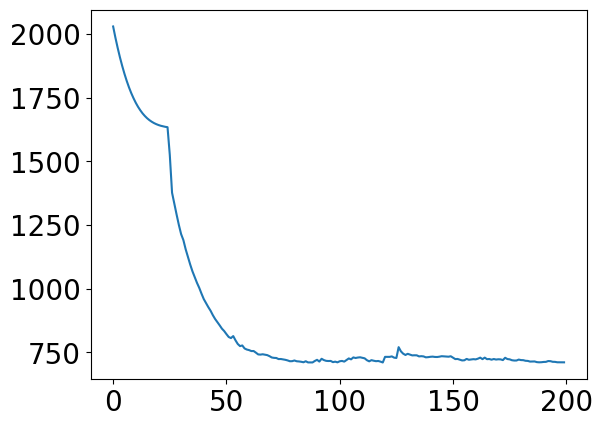

In [37]:
plt.plot(histories[0].history['root_mean_squared_error'], label='Training RMSE')

In [131]:
nn_train_accuracy_mean = np.round(np.mean(nn_train_accuracy), 3)
nn_train_accuracy_std = np.round(np.std(nn_train_accuracy), 3)
nn_test_accuracy_mean = np.round(np.mean(nn_test_accuracy), 3)
nn_test_accuracy_std = np.round(np.std(nn_test_accuracy),3)
nn_r2_mean = np.round(np.mean(nn_r2s),3)
nn_r2_std = np.round(np.std(nn_r2s),3)
nn_time_mean = np.round(np.mean(nn_time),3)
nn_time_std = np.round(np.std(nn_time),3)

print(f"NN Train RMSE: {nn_train_accuracy_mean} ± {nn_train_accuracy_std}")
print(f"NN Test RMSE: {nn_test_accuracy_mean} ± {nn_test_accuracy_std}")
print(f"NN R2: {nn_r2_mean} ± {nn_r2_std}")
print(f"NN Time: {nn_time_mean} ± {nn_time_std}")

NN Train RMSE: 715.947 ± 7.732
NN Test RMSE: 803.581 ± 10.897
NN R2: 0.762 ± 0.006
NN Time: 65.133 ± 2.005


In [91]:
def get_tsl_model(x_train, y_train, number_of_rules):
    tsl_model = TsModel.TsModel(number_of_rules, fuzzification_coefficient=1.2)
    tsl_model.fit(x_train, y_train)
    return tsl_model

def get_tsc_model(x_train, y_train, number_of_rules):
    tsc_model = TsModel_constant.TsModel_constant(number_of_rules, fuzzification_coefficient=1.2)
    tsc_model.fit(x_train, y_train)
    return tsc_model

# TS model
# Linear conclusion

def ts_relu_wrapper(pred):
    return np.maximum(0, pred)

number_of_rules_array = [2,3,4,5,8,10,15,20,25]

FCM training RMSE: 727.3484534820018
FCM training RMSE: 731.3454663278844
FCM training RMSE: 738.0961590697921
FCM training RMSE: 729.8200494982676
FCM training RMSE: 742.0874658911796
FCM training RMSE: 721.5910089695541
FCM training RMSE: 723.7218603004033
FCM training RMSE: 727.720251037819
FCM training RMSE: 715.3299006898262
FCM training RMSE: 711.9013271786125
FCM training RMSE: 711.9532147829837
FCM training RMSE: 715.8074329707265
FCM training RMSE: 720.7073008636149
FCM training RMSE: 714.463678689294
FCM training RMSE: 725.759941000947
FCM training RMSE: 703.5140436469582
FCM training RMSE: 708.7212684962449
FCM training RMSE: 709.904590833444
FCM training RMSE: 695.9398295470186
FCM training RMSE: 694.648472734029
FCM training RMSE: 696.1271543863827
FCM training RMSE: 715.110747855347
FCM training RMSE: 720.0943923629649
FCM training RMSE: 713.7887813270031
FCM training RMSE: 714.615895735258
FCM training RMSE: 708.9199247463586
FCM training RMSE: 705.1086137213997
FCM trai

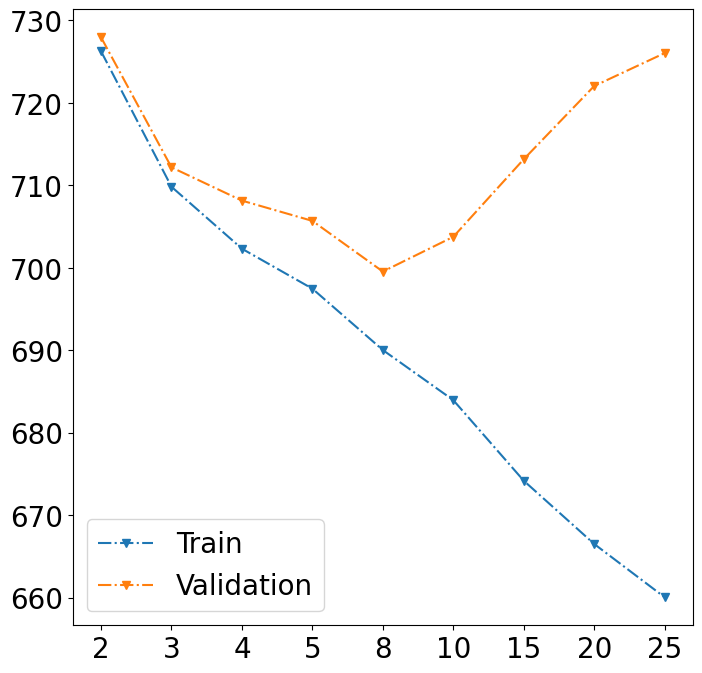

In [124]:
# Use validation to get the optimal number of rules
tsl_cv_train_accuracy = []
tsl_cv_val_accuracy = []

kf = KFold(n_splits=number_of_folds)

for number_of_rules in number_of_rules_array:
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        ts_model = TsModel.TsModel(number_of_rules, fuzzification_coefficient=1.2)
        
        start_time = time.time()
        ts_model.fit(x_train[train_index], y_train[train_index])
        time_used = time.time() - start_time

        tsl_train_pred = ts_relu_wrapper(ts_model.predict(x_train[train_index]))
        tsl_val_pred = ts_relu_wrapper(ts_model.predict(x_train[test_index]))

        train_rmse = root_mean_squared_error(y_train[train_index], tsl_train_pred)
        val_rmse = root_mean_squared_error(y_train[test_index], tsl_val_pred)

        tsl_cv_train_accuracy.append(train_rmse)
        tsl_cv_val_accuracy.append(val_rmse)


# Plot the results
number_of_rules_array_strings = [str(number) for number in number_of_rules_array]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsl_cv_train_accuracy).reshape(-1, 10), axis=1), '-.v', label='Train')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsl_cv_val_accuracy).reshape(-1, 10), axis=1), '-.v', label='Validation')


plt.legend()
plt.show()

(2030, 12)
[[9.53451292e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.31439845e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99512777e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.99839957e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.94864080e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.88594281e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2030, 2)
[[9.53451292e-01 4.65487083e-02]
 [1.31439845e-04 9.99868560e-01]
 [9.99512777e-01 4.87222834e-04]
 ...
 [9.99839957e-01 1.60043399e-04]
 [5.94864080e-03 9.94051359e-01]
 [2.88594281e-02 9.71140572e-01]]
FCM training RMSE: 944.3386152363356
(2030, 12)
[[9.98672377e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.81773445e-04 0.00000000e

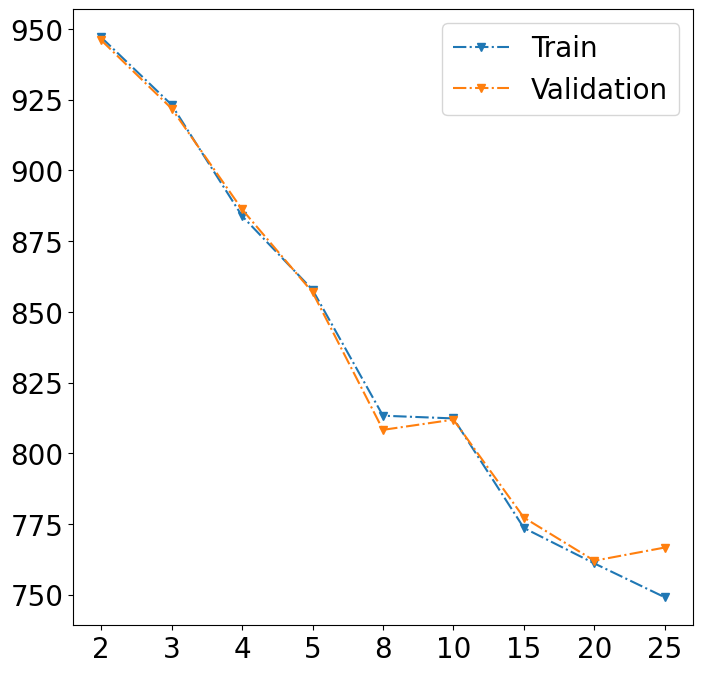

In [122]:
# Use validation to get the optimal number of rules
tsc_cv_train_accuracy = []
tsc_cv_val_accuracy = []

kf = KFold(n_splits=number_of_folds)

for number_of_rules in number_of_rules_array:
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        ts_model = TsModel_constant.TsModel_constant(number_of_rules, fuzzification_coefficient=1.2)
        
        start_time = time.time()
        ts_model.fit(x_train[train_index], y_train[train_index])
        time_used = time.time() - start_time

        tsc_train_pred = ts_relu_wrapper(ts_model.predict(x_train[train_index]))
        tsc_val_pred = ts_relu_wrapper(ts_model.predict(x_train[test_index]))

        train_rmse = root_mean_squared_error(y_train[train_index], tsc_train_pred)
        val_rmse = root_mean_squared_error(y_train[test_index], tsc_val_pred)

        tsc_cv_train_accuracy.append(train_rmse)
        tsc_cv_val_accuracy.append(val_rmse)


# Plot the results
number_of_rules_array_strings = [str(number) for number in number_of_rules_array]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsc_cv_train_accuracy).reshape(-1, 10), axis=1), '-.v', label='Train')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsc_cv_val_accuracy).reshape(-1, 10), axis=1), '-.v', label='Validation')


plt.legend()
plt.show()

In [125]:

# TS with linear conclusion
tsl_opt_train_accuracy = []
tsl_opt_test_accuracy = []
tsl_r2s = []
tsl_time = []
tsl_model = None

for fold in range(number_of_folds):
    ts_model = TsModel.TsModel(number_of_rules=10, fuzzification_coefficient=1.2)
    
    start_time = time.time()
    ts_model.fit(x_train, y_train)
    time_used = time.time() - start_time

    tsl_train_pred = ts_relu_wrapper(ts_model.predict(x_train))
    tsl_test_pred = ts_relu_wrapper(ts_model.predict(x_test))

    train_rmse = root_mean_squared_error(y_train, tsl_train_pred)
    test_rmse = root_mean_squared_error(y_test, tsl_test_pred)

    tsl_opt_train_accuracy.append(train_rmse)
    tsl_opt_test_accuracy.append(test_rmse)
    tsl_r2 = r2_score(y_test, tsl_test_pred)
    tsl_r2s.append(tsl_r2)
    tsl_time.append(time_used)
    tsl_model = ts_model

tsl_train_accuracy_mean = np.round(np.mean(tsl_opt_train_accuracy), 3)
tsl_train_accuracy_std = np.round(np.std(tsl_opt_train_accuracy), 3)
tsl_test_accuracy_mean = np.round(np.mean(tsl_opt_test_accuracy), 3)
tsl_test_accuracy_std = np.round(np.std(tsl_opt_test_accuracy),3)
tsl_r2_mean = np.round(np.mean(tsl_r2s),3)
tsl_r2_std = np.round(np.std(tsl_r2s),3)
tsl_time_mean = np.round(np.mean(tsl_time),3)
tsl_time_std = np.round(np.std(tsl_time),3)

print(f"TS Linear Train RMSE: {tsl_train_accuracy_mean} ± {tsl_train_accuracy_std}")
print(f"TS Linear Test RMSE: {tsl_test_accuracy_mean} ± {tsl_test_accuracy_std}")
print(f"TS Linear R2: {tsl_r2_mean} ± {tsl_r2_std}")
print(f"TS Linear Time: {tsl_time_mean} ± {tsl_time_std}")

FCM training RMSE: 687.243612872598
FCM training RMSE: 684.7121466218159
FCM training RMSE: 684.7121330985409
FCM training RMSE: 686.4958598808166
FCM training RMSE: 686.4405535673844
FCM training RMSE: 684.7121318886847
FCM training RMSE: 684.712132114227
FCM training RMSE: 684.7121481300491
FCM training RMSE: 684.7121470957844
FCM training RMSE: 684.7121467915708
TS Linear Train RMSE: 685.235 ± 0.963
TS Linear Test RMSE: 778.874 ± 3.517
TS Linear R2: 0.776 ± 0.002
TS Linear Time: 0.142 ± 0.06


In [126]:
# TS model
# Constant conclusion
tsc_opt_train_accuracy = []
tsc_opt_test_accuracy = []
tsc_r2s = []
tsc_time = []
tsc_model = None

for fold in range(number_of_folds):
    ts_model = TsModel_constant.TsModel_constant(number_of_rules=10, fuzzification_coefficient=1.2)
    
    start_time = time.time()
    ts_model.fit(x_train, y_train)
    time_used = time.time() - start_time

    tsc_train_pred = ts_relu_wrapper(ts_model.predict(x_train))
    tsc_test_pred = ts_relu_wrapper(ts_model.predict(x_test))

    train_rmse = root_mean_squared_error(y_train, tsc_train_pred)
    test_rmse = root_mean_squared_error(y_test, tsc_test_pred)

    tsc_opt_train_accuracy.append(train_rmse)
    tsc_opt_test_accuracy.append(test_rmse)
    tsc_r2 = r2_score(y_test, tsc_test_pred)
    tsc_r2s.append(tsc_r2)
    tsc_time.append(time_used)
    tsc_model = ts_model

tsc_train_accuracy_mean = np.round(np.mean(tsc_opt_train_accuracy), 3)
tsc_train_accuracy_std = np.round(np.std(tsc_opt_train_accuracy), 3)
tsc_test_accuracy_mean = np.round(np.mean(tsc_opt_test_accuracy), 3)
tsc_test_accuracy_std = np.round(np.std(tsc_opt_test_accuracy),3)
tsc_r2_mean = np.round(np.mean(tsc_r2s),3)
tsc_r2_std = np.round(np.std(tsc_r2s),3)
tsc_time_mean = np.round(np.mean(tsc_time),3)
tsc_time_std = np.round(np.std(tsc_time),3)

print(f"TS Constant Train RMSE: {tsc_train_accuracy_mean} ± {tsc_train_accuracy_std}")
print(f"TS Constant Test RMSE: {tsc_test_accuracy_mean} ± {tsc_test_accuracy_std}")
print(f"TS Constant R2: {tsc_r2_mean} ± {tsc_r2_std}")
print(f"TS Constant Time: {tsc_time_mean} ± {tsc_time_std}")

(2256, 60)
[[7.37409589e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99954509e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.34855173e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.85224079e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.22409342e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.68079878e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 10)
[[7.37409589e-05 2.13554902e-03 1.46219718e-03 ... 1.01517393e-02
  9.35758800e-01 3.14405112e-04]
 [9.99954509e-01 4.22385232e-06 9.83802860e-08 ... 7.15277982e-08
  3.28327633e-06 2.80562084e-08]
 [1.34855173e-03 7.19550680e-07 2.12108222e-08 ... 1.23010041e-08
  7.68040912e-06 2.71728858e-08]
 ...
 [6.85224079e-09 6.10281197e-07 4.96436189e-04 ... 3.81704602e-07
  1.628668

In [41]:
# GPR model
gp_train_accuracy = []
gp_test_accuracy = []
gp_r2s = []
gp_time = []
gpr_model = None

for fold in range(number_of_folds):
    
    kernel = 1.0 * Matern(length_scale=1e-1, nu=1.5)
    gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
    indices = np.random.choice(x_train.shape[0], 2000, replace=False)      

    start_time = time.time()
    gpr_model.fit(x_train[indices,:], y_train[indices,:])
    time_used = time.time() - start_time

    train_means = gpr_model.predict(x_train)
    test_means = gpr_model.predict(x_test)

    train_rmse = root_mean_squared_error(y_train, train_means)
    test_rmse = root_mean_squared_error(y_test, test_means)

    gp_train_accuracy.append(train_rmse)
    gp_test_accuracy.append(test_rmse)
    gp_r2 = r2_score(y_test, test_means)
    gp_r2s.append(gp_r2)
    gp_time.append(time_used)

gp_train_accuracy_mean = np.round(np.mean(gp_train_accuracy), 3)
gp_train_accuracy_std = np.round(np.std(gp_train_accuracy), 3)
gp_test_accuracy_mean = np.round(np.mean(gp_test_accuracy), 3)
gp_test_accuracy_std = np.round(np.std(gp_test_accuracy),3)
gp_r2_mean = np.round(np.mean(gp_r2s),3)
gp_r2_std = np.round(np.std(gp_r2s),3)
gp_time_mean = np.round(np.mean(gp_time),3)
gp_time_std = np.round(np.std(gp_time),3)

print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
print(f"GP Time: {gp_time_mean} ± {gp_time_std}")


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

GP Train RMSE: 609.583 ± 143.467
GP Test RMSE: 1769.605 ± 446.094
GP R2: -0.228 ± 0.518
GP Time: 16.736 ± 8.892


In [46]:
# GPR from TS linear
gp_tsl_train_accuracy = []
gp_tsl_test_accuracy = []
tsl_train_accuracy = []
tsl_test_accuracy = []
gp_tsl_r2s = []
gp_tsl_time = []
gpr_tsl_model = None

# From ts linear
for number_of_rules in number_of_rules_array:
    for fold in range(number_of_folds):
        
        kernel = 1.0 * Matern(length_scale=1e-1, nu=1.5)
        gpr_tsl_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
        tsl_model = get_tsl_model(x_train, y_train, number_of_rules)

        start_time = time.time()
        gpr_tsl_model.fit(tsl_model.cen, tsl_model.predict(tsl_model.cen + 1e-8))
        time_used = time.time() - start_time

        gp_train_means = gpr_tsl_model.predict(x_train)
        gp_test_means = gpr_tsl_model.predict(x_test)

        tsl_train_means = tsl_model.predict(x_train)
        tsl_test_means = tsl_model.predict(x_test)

        gp_train_rmse = root_mean_squared_error(y_train, gp_train_means)
        gp_test_rmse = root_mean_squared_error(y_test, gp_test_means)

        gp_tsl_train_accuracy.append(gp_train_rmse)
        gp_tsl_test_accuracy.append(gp_test_rmse)
        tsl_train_accuracy.append(root_mean_squared_error(y_train, tsl_train_means))
        tsl_test_accuracy.append(root_mean_squared_error(y_test, tsl_test_means))
        gp_r2 = r2_score(y_test, gp_test_means)
        gp_tsl_r2s.append(gp_r2)
        gp_tsl_time.append(time_used)

for idx, number_of_rules in enumerate(number_of_rules_array):
    gp_train_accuracy_mean = np.round(np.mean(gp_tsl_train_accuracy[idx*10:idx*10+10]), 3)
    gp_train_accuracy_std = np.round(np.std(gp_tsl_train_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_mean = np.round(np.mean(gp_tsl_test_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_std = np.round(np.std(gp_tsl_test_accuracy[idx*10:idx*10+10]),3)
    gp_r2_mean = np.round(np.mean(gp_tsl_r2s[idx*10:idx*10+10]),3)
    gp_r2_std = np.round(np.std(gp_tsl_r2s[idx*10:idx*10+10]),3)
    gp_time_mean = np.round(np.mean(gp_tsl_time[idx*10:idx*10+10]),3)
    gp_time_std = np.round(np.std(gp_tsl_time[idx*10:idx*10+10]),3)

    print(f"Number of rules: {number_of_rules}")
    print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
    print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
    print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
    print(f"GP Time: {gp_time_mean} ± {gp_time_std}")


FCM training RMSE: 727.2435294896957
FCM training RMSE: 727.2435244993485
FCM training RMSE: 727.2435249465886
FCM training RMSE: 727.2435259728553
FCM training RMSE: 727.2435264769277
FCM training RMSE: 727.2435222819125
FCM training RMSE: 727.2435233181968


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 727.243524311869
FCM training RMSE: 727.2435256950264
FCM training RMSE: 727.2435267197294
FCM training RMSE: 710.5560671737016
FCM training RMSE: 710.5560780098002
FCM training RMSE: 710.556077909126
FCM training RMSE: 710.5560678088067
FCM training RMSE: 710.5560681454591


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 710.5560651227042
FCM training RMSE: 710.5560662258782
FCM training RMSE: 710.5560765730917
FCM training RMSE: 710.5560680169166
FCM training RMSE: 710.5560653864
FCM training RMSE: 715.9270118079288
FCM training RMSE: 696.0571307145816
FCM training RMSE: 715.9270136553213
FCM training RMSE: 696.0571289565803
FCM training RMSE: 696.0571412841683


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 715.9270110168889
FCM training RMSE: 709.9474620380803
FCM training RMSE: 715.9270272580749
FCM training RMSE: 696.0571255304413
FCM training RMSE: 696.0571369358273


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 696.362858250467
FCM training RMSE: 710.4612981595686
FCM training RMSE: 696.5534227763757


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 696.5534210924856
FCM training RMSE: 696.3628382513278
FCM training RMSE: 696.3628580880463
FCM training RMSE: 696.5534173419297
FCM training RMSE: 706.1190900632381


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 696.553422218637
FCM training RMSE: 710.4612978344928


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 690.0800560910633


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 690.0800565971315
FCM training RMSE: 690.0800563381757


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 690.5048898974817


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 690.0800563243928


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 694.3942288466965
FCM training RMSE: 690.080056687517


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 690.0800561738731
FCM training RMSE: 687.0728294317946


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 690.0800443257333


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 684.7121330335941


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 684.7378213816986


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 689.3332133094535
FCM training RMSE: 686.4778986928948


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 684.712146749228
FCM training RMSE: 684.7121321546616


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 687.2448777468213
FCM training RMSE: 684.7121475789221


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 684.7121320955135


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 686.7728835573203


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 676.4306487589342


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 676.4306647095614


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 676.6199621764509


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 678.7214493367045


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 677.717016134712


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 675.8660489198005


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 679.5321348494335


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 678.1052723119521


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 673.177604146678


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 679.9141803772673


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 673.2919484944931


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 674.0211511113076


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 664.6789635764105


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 674.0655143650692


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 673.9750328247105


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 668.532297027113


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 673.7443461384107


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 674.5131995308291


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 672.8626336285787


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 671.724065810002


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 664.5983710217575


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 668.2297251114072


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 667.0773260760338


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 669.45458540131


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 670.1954515864365


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 669.7256817910998


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 669.6050682282201


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 659.4814939441958


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 667.7692095207747


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 670.9787588188236
Number of rules: 2
GP Train RMSE: 1607.976 ± 361.538
GP Test RMSE: 1629.25 ± 351.911
GP R2: -0.024 ± 0.441
GP Time: 0.019 ± 0.005
Number of rules: 3
GP Train RMSE: 1393.446 ± 329.31
GP Test RMSE: 1420.609 ± 320.462
GP R2: 0.218 ± 0.393
GP Time: 0.018 ± 0.007
Number of rules: 4
GP Train RMSE: 1614.271 ± 536.376
GP Test RMSE: 1631.435 ± 526.91
GP R2: -0.084 ± 0.592
GP Time: 0.017 ± 0.007
Number of rules: 5
GP Train RMSE: 1750.951 ± 460.428
GP Test RMSE: 1765.931 ± 452.226
GP R2: -0.225 ± 0.522
GP Time: 0.017 ± 0.007
Number of rules: 8
GP Train RMSE: 1057.569 ± 497.305
GP Test RMSE: 1104.032 ± 478.803
GP R2: 0.466 ± 0.517
GP Time: 0.019 ± 0.011
Number of rules: 10
GP Train RMSE: 1168.041 ± 578.769
GP Test RMSE: 1211.118 ± 556.707
GP R2: 0.345 ± 0.597
GP Time: 0.019 ± 0.005
Number of rules: 15
GP Train RMSE: 746.987 ± 3.92
GP Test RMSE: 804.278 ± 4.023
GP R2: 0.761 ± 0.002
GP Time: 0.024 ± 0.007
Number of rules: 20
GP Train RMSE: 734.02 ± 4.31
GP Test R

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [56]:
# GPR model
gp_tsc_train_accuracy = []
gp_tsc_test_accuracy = []
tsc_train_accuracy = []
tsc_test_accuracy = []
gp_tsc_r2s = []
gp_tsc_time = []
gpr_tsc_model = None

# From ts constant
for number_of_rules in number_of_rules_array:
    for fold in range(number_of_folds):
        
        kernel = 1.0 * Matern(length_scale=1e-1, nu=1.5)
        gpr_tsc_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
        tsc_model = get_tsc_model(x_train, y_train, number_of_rules)
        start_time = time.time()
        gpr_tsc_model.fit(tsc_model.cen, tsc_model.predict(tsc_model.cen + 1e-8))
        time_used = time.time() - start_time

        train_means = gpr_tsc_model.predict(x_train)
        test_means = gpr_tsc_model.predict(x_test)
        tsc_train_means = tsc_model.predict(x_train)
        tsc_test_means = tsc_model.predict(x_test)

        train_rmse = root_mean_squared_error(y_train, train_means)
        test_rmse = root_mean_squared_error(y_test, test_means)

        gp_tsc_train_accuracy.append(train_rmse)
        gp_tsc_test_accuracy.append(test_rmse)
        tsc_train_accuracy.append(root_mean_squared_error(y_train, tsc_train_means))
        tsc_test_accuracy.append(root_mean_squared_error(y_test, tsc_test_means))
        gp_r2 = r2_score(y_test, test_means)
        gp_tsc_r2s.append(gp_r2)
        gp_tsc_time.append(time_used)


for idx, number_of_rules in enumerate(number_of_rules_array):
    gp_train_accuracy_mean = np.round(np.mean(gp_tsc_train_accuracy[idx*10:idx*10+10]), 3)
    gp_train_accuracy_std = np.round(np.std(gp_tsc_train_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_mean = np.round(np.mean(gp_tsc_test_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_std = np.round(np.std(gp_tsc_test_accuracy[idx*10:idx*10+10]),3)
    gp_r2_mean = np.round(np.mean(gp_tsc_r2s[idx*10:idx*10+10]),3)
    gp_r2_std = np.round(np.std(gp_tsc_r2s[idx*10:idx*10+10]),3)
    gp_time_mean = np.round(np.mean(gp_tsc_time[idx*10:idx*10+10]),3)
    gp_time_std = np.round(np.std(gp_tsc_time[idx*10:idx*10+10]),3)

    print(f"Number of rules: {number_of_rules}")
    print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
    print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
    print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
    print(f"GP Time: {gp_time_mean} ± {gp_time_std}")


(2256, 12)
[[9.98611235e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.93615959e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.75717126e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.99836783e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.74791984e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.85636265e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 2)
[[9.98611235e-01 1.38876532e-03]
 [1.93615959e-04 9.99806384e-01]
 [8.75717126e-06 9.99991243e-01]
 ...
 [9.99836783e-01 1.63217260e-04]
 [5.74791984e-03 9.94252080e-01]
 [2.85636265e-02 9.71436374e-01]]
FCM training RMSE: 947.0528804622251
(2256, 12)
[[1.38876489e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99806384e-01 0.00000000e

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 947.0528803392347
(2256, 12)
[[1.38876377e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99806384e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99991243e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.63217176e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.94252077e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.71436351e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 2)
[[1.38876377e-03 9.98611236e-01]
 [9.99806384e-01 1.93615863e-04]
 [9.99991243e-01 8.75716030e-06]
 ...
 [1.63217176e-04 9.99836783e-01]
 [9.94252077e-01 5.74792297e-03]
 [9.71436351e-01 2.85636492e-02]]
FCM training RMSE: 947.0528877183035
(2256, 18)
[[6.21566407e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

(2256, 18)
[[5.73379686e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99804502e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99994853e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.86364760e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.91148144e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.81848208e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 3)
[[5.73379686e-03 6.21566661e-02 9.32109537e-01]
 [9.99804502e-01 1.35435670e-04 6.00619529e-05]
 [9.99994853e-01 3.56134459e-06 1.58523729e-06]
 ...
 [3.86364760e-06 9.99582970e-01 4.13165920e-04]
 [9.91148144e-01 7.11764073e-03 1.73421487e-03]
 [7.81848208e-01 2.11624690e-01 6.52710275e-03]]
FCM training RMSE: 915.8796940066387
(2256, 18)
[[6.21566492e-02 0.00000000e+00 0.000

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

(2256, 24)
[[2.10799066e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.80046125e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.42042334e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91017901e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.83639239e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.99322240e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 4)
[[2.10799066e-01 4.94547705e-03 2.49869721e-02 7.59268485e-01]
 [2.80046125e-04 9.99624986e-01 5.68700635e-05 3.80976286e-05]
 [1.42042334e-06 9.99996061e-01 1.97501018e-06 5.43614073e-07]
 ...
 [1.91017901e-02 5.79548610e-06 9.80171310e-01 7.21103914e-04]
 [5.83639239e-02 9.37322822e-01 2.54213000e-03 1.77112360e-03]
 [6.99322240e-01 2.78231916e-01 1.97181265e-02 2.72771743e-

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

(2256, 24)
[[1.11549575e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.36742630e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.18204524e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.99959379e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.90756514e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.45936978e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 4)
[[1.11549575e-02 1.64677231e-01 4.07495804e-04 8.23760316e-01]
 [2.36742630e-05 1.42151337e-05 9.97883306e-01 2.07880416e-03]
 [6.18204524e-08 3.91906427e-08 9.99987251e-01 1.26480906e-05]
 ...
 [9.99959379e-01 2.24853302e-05 8.34181454e-08 1.80522682e-05]
 [4.90756514e-03 1.63938369e-03 4.01744259e-01 5.91708792e-01]
 [2.45936978e-02 1.54523128e-03 7.50337220e-02 8.98827349e-

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 30)
[[8.76448787e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.83565796e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.16551166e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.93444750e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.83556653e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.59440132e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 5)
[[8.76448787e-04 9.36036368e-05 3.63829624e-02 5.21888220e-03
  9.57428103e-01]
 [1.83565796e-05 9.94875500e-01 1.68307322e-05 8.19009098e-05
  5.00741136e-03]
 [2.16551166e-07 9.99914762e-01 9.31913095e-08 1.75265742e-07
  8.47531431e-05]
 ...
 [9.93444750e-01 4.84020269e-07 1.25639815e-04 6.37289044e-03
  5.62357548e-05]
 [9.83556653e-04 2.10444868e-01 9.41773669e-04 1.58706

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

(2256, 30)
[[1.19764488e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.73446835e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.78133491e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.24081360e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.22356305e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.84190823e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 5)
[[1.19764488e-01 4.65812961e-02 1.24007784e-03 1.89432669e-02
  8.13470871e-01]
 [9.73446835e-04 9.39410014e-06 9.98968137e-01 2.01404801e-05
  2.88820590e-05]
 [4.78133491e-06 5.53442533e-08 9.99995074e-01 5.33870755e-08
  3.55577056e-08]
 ...
 [4.24081360e-06 5.54702281e-06 2.21329550e-08 9.99988314e-01
  1.87642496e-06]
 [2.22356305e-01 8.95939316e-04 7.64531323e-01 5.27203

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 30)
[[3.63829521e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.68307337e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.31913122e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.25639827e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.41773587e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.84025246e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 5)
[[3.63829521e-02 9.57428115e-01 5.21888069e-03 8.76448563e-04
  9.36036127e-05]
 [1.68307337e-05 5.00741193e-03 8.19009165e-05 1.83565815e-05
  9.94875500e-01]
 [9.31913122e-08 8.47531414e-05 1.75265747e-07 2.16551177e-07
  9.99914762e-01]
 ...
 [1.25639827e-04 5.62357607e-05 6.37289108e-03 9.93444749e-01
  4.84020323e-07]
 [9.41773587e-04 7.71759164e-01 1.58706600e-02 9.83556

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 968.8051017818673
(2256, 30)
[[9.35996206e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.94875407e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99914762e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.84029463e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.10441440e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.99916430e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 5)
[[9.35996206e-05 9.57430122e-01 3.63812355e-02 5.21863214e-03
  8.76411035e-04]
 [9.94875407e-01 5.00750319e-03 1.68309655e-05 8.19020407e-05
  1.83568927e-05]
 [9.99914762e-01 8.47530208e-05 9.31919296e-08 1.75266966e-07
  2.16553479e-07]
 ...
 [4.84029463e-07 5.62367341e-05 1.25641714e-04 6.37299284e-03
  9.93444645e-01]
 [2.10441440e-01 

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 48)
[[3.44209033e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.27025601e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.85984612e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.83175947e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.61882600e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.24647649e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 8)
[[3.44209033e-03 4.87144148e-05 3.70341521e-06 ... 2.49525678e-04
  9.95892686e-01 2.99553122e-04]
 [1.27025601e-07 1.57745942e-06 7.24209433e-05 ... 4.06645400e-08
  1.16497134e-05 2.76786491e-07]
 [1.85984612e-08 1.24481724e-06 9.98865458e-01 ... 2.56593077e-08
  9.15267437e-06 3.38498597e-08]
 ...
 [2.83175947e-06 2.92334650e-06 3.28709174e-08 ... 7.76152749e-06
  5.9453713

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 48)
[[5.08350945e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.54064955e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.45943495e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.37652719e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.24095394e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.24297628e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 8)
[[5.08350945e-04 5.47628833e-03 1.20689820e-04 ... 2.12807900e-04
  9.84713334e-01 8.91829097e-03]
 [2.54064955e-05 9.50509049e-06 7.97913992e-06 ... 7.27008945e-04
  1.40132020e-02 3.13787769e-04]
 [1.45943495e-08 1.33956407e-08 2.12622755e-08 ... 3.97638063e-07
  2.49536925e-06 4.91198316e-06]
 ...
 [1.37652719e-03 6.05048117e-06 9.98610501e-01 ... 1.12687254e-06
  1.0093684

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 48)
[[1.18471439e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99913844e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.12402801e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.74309050e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.19520603e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.05303520e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 8)
[[1.18471439e-05 4.87143691e-05 3.44208681e-03 ... 9.95892690e-01
  3.70341198e-06 5.18795950e-05]
 [9.99913844e-01 1.57745934e-06 1.27025593e-07 ... 1.16497169e-05
  7.24209397e-05 6.37350172e-08]
 [1.12402801e-03 1.24481739e-06 1.85984628e-08 ... 9.15267554e-06
  9.98865457e-01 3.89937527e-08]
 ...
 [2.74309050e-08 2.92334661e-06 2.83175948e-06 ... 5.94537080e-06
  3.2870919

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 48)
[[1.18462746e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99913844e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.12404404e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.74307532e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.19515958e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.05304921e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 8)
[[1.18462746e-05 2.49511061e-04 9.95892959e-01 ... 2.99533951e-04
  3.70320250e-06 3.44185864e-03]
 [9.99913844e-01 4.06645259e-08 1.16499437e-05 ... 2.76785641e-07
  7.24207060e-05 1.27025094e-07]
 [1.12404404e-03 2.56595469e-08 9.15275157e-06 ... 3.38500794e-08
  9.98865441e-01 1.85985662e-08]
 ...
 [2.74307532e-08 7.76154655e-06 5.94533590e-06 ... 8.18760900e-04
  3.2871045

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 48)
[[8.37908179e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.39128440e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.77325240e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.06684406e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.20200948e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00561570e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 8)
[[8.37908179e-03 8.13493484e-01 1.16670038e-03 ... 1.11404565e-01
  5.52642595e-02 8.39103034e-03]
 [4.39128440e-05 6.89982790e-02 2.87999240e-04 ... 2.19329014e-05
  8.10485237e-04 7.18757556e-06]
 [1.77325240e-08 5.83128009e-06 8.21853608e-07 ... 1.04307701e-08
  1.53239029e-05 1.44693794e-08]
 ...
 [1.06684406e-03 8.16697023e-07 2.26962158e-06 ... 3.18272236e-06
  2.5039845

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 48)
[[1.76828713e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.14949867e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.25186507e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.98915658e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.89247686e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.36076857e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 8)
[[1.76828713e-03 5.52599257e-02 1.11396880e-01 ... 8.13506759e-01
  8.37853550e-03 8.39051250e-03]
 [1.14949867e-05 8.10471753e-04 2.19323708e-05 ... 6.89934416e-02
  4.39118140e-05 7.18742052e-06]
 [2.25186507e-08 1.53246364e-05 1.04311031e-08 ... 5.83130591e-06
  1.77331050e-08 1.44698778e-08]
 ...
 [9.98915658e-01 2.50399569e-06 3.18276222e-06 ... 8.16729023e-07
  1.0668610

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 60)
[[8.90382850e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.90626848e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.14633282e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.17836165e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.86969451e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.05688293e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 10)
[[8.90382850e-03 7.19370724e-04 1.53756353e-04 ... 9.83480278e-01
  5.55045324e-03 2.19640540e-04]
 [3.90626848e-08 9.92498479e-08 2.82369487e-08 ... 4.16425332e-06
  7.42579352e-08 1.39370542e-08]
 [2.14633282e-08 2.20428194e-08 2.81984828e-08 ... 8.13486495e-06
  1.32372035e-08 1.99012612e-08]
 ...
 [2.17836165e-06 4.90250922e-04 9.99501817e-01 ... 1.55279836e-06
  3.946939

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 60)
[[1.42425250e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.28489402e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.52758742e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.72012257e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.06987281e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99832583e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 10)
[[1.42425250e-04 3.31155066e-04 3.64027641e-05 ... 9.51346275e-03
  9.85539799e-01 4.83587789e-06]
 [3.28489402e-06 2.86381877e-08 3.43710187e-07 ... 1.79390137e-06
  6.90531147e-05 5.67626387e-05]
 [4.52758742e-07 1.90054823e-08 5.98709390e-07 ... 5.48117988e-06
  3.34001602e-06 9.98313674e-01]
 ...
 [4.72012257e-07 1.93747588e-06 1.61119351e-06 ... 1.54460421e-06
  3.804680

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 60)
[[4.83588675e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.67629264e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.98313684e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [8.00046028e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.21210011e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.47999625e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 10)
[[4.83588675e-06 1.42426126e-04 6.47919175e-05 ... 9.51348603e-03
  3.31155753e-04 4.06098866e-03]
 [5.67629264e-05 3.28489049e-06 4.12383779e-08 ... 1.79390872e-06
  2.86383149e-08 8.59621808e-08]
 [9.98313684e-01 4.52754255e-07 2.54013608e-08 ... 5.48115513e-06
  1.90054075e-08 1.36306179e-08]
 ...
 [8.00046028e-09 4.72021933e-07 9.99522400e-01 ... 1.54462567e-06
  1.937501

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 60)
[[9.99212523e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.87279048e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.16067816e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.95140241e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.93255109e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.76967937e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 10)
[[9.99212523e-01 3.78906157e-05 9.24140731e-06 ... 4.91393781e-04
  7.93660181e-07 1.64580922e-05]
 [2.87279048e-05 1.35870996e-07 4.11612540e-07 ... 8.01210933e-08
  4.72355474e-05 2.35873614e-08]
 [1.16067816e-05 3.49735951e-08 1.54383872e-06 ... 2.35866495e-08
  9.97189766e-01 4.14649193e-08]
 ...
 [6.95140241e-07 4.40423939e-04 2.31342657e-06 ... 6.68018617e-07
  9.280197

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 60)
[[3.64027595e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.43710363e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.98709490e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.61119359e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.16584533e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.89527588e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 10)
[[3.64027595e-05 4.06098004e-03 1.42425301e-04 ... 7.96115708e-06
  9.51346410e-03 6.47917126e-05]
 [3.43710363e-07 8.59618156e-08 3.28489381e-06 ... 9.99868462e-01
  1.79390179e-06 4.12381592e-08]
 [5.98709490e-07 1.36306675e-08 4.52758479e-07 ... 1.67637512e-03
  5.48117841e-06 2.54014164e-08]
 ...
 [1.61119359e-06 7.13204585e-07 4.72012826e-07 ... 4.68071819e-09
  1.544605

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 90)
[[9.61193148e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.01648510e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.78378057e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.59346227e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.85640539e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.22349365e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 15)
[[9.61193148e-01 6.35281869e-05 3.63310686e-04 ... 7.46142976e-05
  8.27361459e-06 1.68243526e-04]
 [3.01648510e-05 1.40013379e-08 3.98128222e-08 ... 6.23787869e-08
  9.99912204e-01 5.25765261e-08]
 [6.78378057e-07 4.06885822e-09 3.97908162e-09 ... 3.37586205e-08
  3.84368529e-04 2.43729918e-09]
 ...
 [9.59346227e-08 9.94707559e-01 5.27067377e-03 ... 5.29483433e-06
  1.118249

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 90)
[[1.57528231e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.06015069e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.12883124e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.98186045e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.39347607e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.86485225e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 15)
[[1.57528231e-04 6.34764211e-06 2.34772732e-05 ... 3.71220963e-03
  6.59813831e-06 2.75010441e-04]
 [7.06015069e-06 9.99921306e-01 7.24474650e-08 ... 2.62655286e-08
  1.53103849e-06 8.36597967e-09]
 [2.12883124e-04 2.80071594e-04 4.91037414e-08 ... 1.83300442e-09
  1.39801158e-05 2.42139319e-09]
 ...
 [2.98186045e-09 1.86549020e-10 7.35113114e-08 ... 3.29880117e-08
  1.375688

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 90)
[[3.43991033e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.45716898e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.64699106e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.22708169e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.22953137e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.78990035e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 15)
[[3.43991033e-06 4.40222473e-07 7.24310300e-07 ... 6.60859738e-06
  9.99475117e-01 8.68800732e-07]
 [4.45716898e-08 7.43121888e-05 6.20830370e-08 ... 6.89043562e-02
  2.17735478e-05 2.71228390e-07]
 [1.64699106e-08 4.60407071e-06 2.09196190e-08 ... 1.88334751e-04
  9.28026402e-07 1.69092108e-07]
 ...
 [4.22708169e-07 1.11902257e-08 9.99775934e-01 ... 7.32162795e-09
  2.754333

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 90)
[[7.75525064e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.41270543e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.24393690e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97342298e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.98876157e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.46301069e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 15)
[[7.75525064e-06 2.07996689e-02 3.71253536e-03 ... 2.74683569e-04
  1.70261547e-06 2.53865241e-04]
 [1.41270543e-06 3.36479866e-07 3.36281426e-08 ... 1.07049342e-08
  2.47312777e-05 3.18956049e-07]
 [8.24393690e-06 2.80820964e-07 2.40065238e-09 ... 3.16952151e-09
  9.99348585e-01 1.95324464e-08]
 ...
 [1.97342298e-09 2.06871894e-07 3.48569008e-08 ... 8.90693967e-08
  1.857584

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 90)
[[1.23559412e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.32758553e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99795328e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.74862529e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.70971444e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.62178359e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 15)
[[1.23559412e-07 6.35507905e-07 2.18812558e-04 ... 7.08348614e-06
  9.99406504e-01 2.51225725e-07]
 [1.32758553e-04 4.30968727e-08 1.39896485e-07 ... 2.01873098e-07
  2.88699450e-05 7.75330400e-06]
 [9.99795328e-01 2.23960601e-09 2.08986420e-09 ... 1.80703098e-09
  1.28237041e-07 8.08653497e-06]
 ...
 [3.74862529e-10 1.53122990e-03 8.87051125e-08 ... 4.93347500e-05
  5.857223

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 90)
[[3.91027559e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.27920518e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.00328232e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [8.65973915e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.04830733e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.40553203e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 15)
[[3.91027559e-04 2.00191797e-04 2.13164353e-04 ... 1.22566465e-05
  1.74293853e-03 9.57393402e-01]
 [2.27920518e-08 2.05686387e-06 1.94474044e-05 ... 6.29695339e-06
  7.17463323e-08 6.63381827e-05]
 [3.00328232e-09 5.58241357e-08 2.88580692e-04 ... 1.60893127e-05
  1.63075213e-09 6.08567858e-07]
 ...
 [8.65973915e-08 2.89774883e-08 2.97886994e-09 ... 1.54071337e-09
  1.543429

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 90)
[[1.55565403e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.27013250e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.44089117e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.99076357e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.41566591e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.52490680e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 15)
[[1.55565403e-06 1.00341141e-04 3.41002751e-08 ... 2.08968082e-07
  3.71023066e-05 4.52714154e-06]
 [7.27013250e-08 2.35089173e-06 9.54271774e-01 ... 2.91604125e-08
  1.04278060e-07 7.40405660e-07]
 [2.44089117e-09 5.67764915e-07 1.55437041e-04 ... 1.79586674e-09
  1.27570817e-09 6.90177066e-09]
 ...
 [9.99076357e-01 4.22044778e-08 7.84683803e-11 ... 8.90372541e-04
  2.016648

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 90)
[[4.11357082e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.39845577e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.28531378e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.48180903e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.70477342e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.41407366e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 15)
[[4.11357082e-08 2.64503251e-07 1.90097810e-04 ... 1.99434117e-06
  1.33592311e-05 3.46073881e-05]
 [9.39845577e-01 5.76623015e-07 2.60548795e-06 ... 3.64433528e-06
  1.03587339e-07 2.02200522e-07]
 [2.28531378e-04 6.90408227e-08 4.21401428e-07 ... 3.69967084e-08
  3.79269556e-09 2.46433407e-09]
 ...
 [1.48180903e-10 7.52355578e-08 1.52391180e-07 ... 5.74947912e-08
  1.040206

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 90)
[[2.55845011e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.08037519e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.03893951e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.89890340e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.14744333e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.19110555e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 15)
[[2.55845011e-05 7.93828863e-05 1.00261974e-05 ... 1.68219171e-03
  2.42706528e-02 1.04108407e-02]
 [2.08037519e-08 1.46252839e-07 9.99846083e-01 ... 7.58268443e-08
  9.15467546e-07 7.19525582e-08]
 [4.03893951e-09 3.94632033e-08 3.34271680e-04 ... 2.07429137e-09
  4.54348931e-07 3.99835266e-09]
 ...
 [4.89890340e-04 3.03586954e-07 8.37532589e-11 ... 5.88728892e-09
  6.448914

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 120)
[[9.83189056e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.39575156e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.07353114e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [8.43676050e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.76010316e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.72465207e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 20)
[[9.83189056e-01 3.19164268e-06 4.45936046e-07 ... 1.67021382e-02
  4.23565721e-07 3.39572174e-05]
 [3.39575156e-07 1.22456757e-08 1.25125096e-08 ... 1.84015060e-05
  2.16648334e-08 2.51640273e-06]
 [3.07353114e-07 1.86595615e-08 1.56851847e-08 ... 1.86964938e-06
  5.38951060e-08 3.82725526e-05]
 ...
 [8.43676050e-08 1.60294231e-08 9.99929911e-01 ... 4.99076522e-09
  7.46287

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 120)
[[2.28495110e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.58157046e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.75986962e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.71119481e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.30204639e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.44351916e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 20)
[[2.28495110e-09 7.29047592e-10 5.35988279e-09 ... 3.93042489e-08
  4.88819960e-08 9.90859945e-11]
 [2.58157046e-05 8.70247124e-07 4.61623292e-08 ... 8.75172670e-08
  2.16627775e-08 1.15288244e-05]
 [1.75986962e-01 2.99339711e-05 1.65270376e-07 ... 3.72354766e-08
  8.56532002e-09 8.21223982e-01]
 ...
 [4.71119481e-09 1.17546650e-08 5.58313582e-06 ... 1.93289029e-05
  3.73761

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 120)
[[2.38342159e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.37034308e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.02883728e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.17285617e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.11157560e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.73190462e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 20)
[[2.38342159e-07 9.81294158e-07 9.98645481e-01 ... 5.74194449e-07
  3.76556562e-08 1.02082103e-07]
 [7.37034308e-06 1.38237599e-04 2.54607633e-05 ... 3.20213385e-08
  5.87753258e-05 9.18648215e-01]
 [8.02883728e-05 1.22251840e-01 9.69505895e-07 ... 1.37854233e-08
  8.76244072e-01 1.21030007e-03]
 ...
 [1.17285617e-11 7.36090480e-12 3.39239297e-10 ... 1.43210748e-05
  1.11646

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 120)
[[7.71472999e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.39217776e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.16295816e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [5.16472779e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.67901307e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.35719921e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 20)
[[7.71472999e-08 2.02514789e-09 9.99934411e-01 ... 1.10851351e-07
  6.88948362e-09 1.15782120e-06]
 [3.39217776e-09 1.37147587e-02 1.00567812e-06 ... 1.58453577e-08
  9.37674787e-07 1.49682051e-08]
 [2.16295816e-09 9.32710964e-05 6.66813523e-08 ... 8.69306675e-09
  1.46962054e-05 1.27044859e-09]
 ...
 [5.16472779e-08 9.67911549e-11 7.40733907e-08 ... 9.69816529e-05
  1.22458

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 120)
[[3.00827502e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.31622992e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.32873716e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.44800862e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.06833190e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.74284178e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 20)
[[3.00827502e-06 4.61107549e-09 3.52246988e-07 ... 6.60947891e-08
  1.06714951e-04 8.29923196e-09]
 [1.31622992e-07 1.04025530e-04 3.61859288e-05 ... 8.50085201e-05
  2.87282553e-05 9.15748058e-01]
 [1.32873716e-09 9.99475106e-01 2.72473071e-04 ... 8.17751117e-07
  1.79183822e-07 2.06007481e-04]
 ...
 [1.44800862e-08 1.70454443e-10 2.68030796e-09 ... 1.61950034e-09
  7.65952

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 120)
[[9.46391363e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.25128596e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.11448013e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [5.66272890e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.27477041e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.80620371e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 20)
[[9.46391363e-07 1.00981139e-06 1.27598259e-06 ... 5.32623897e-03
  8.52129255e-06 3.05958867e-06]
 [1.25128596e-07 1.98327446e-07 2.73763711e-01 ... 8.09591590e-05
  1.39425791e-07 4.72158918e-07]
 [6.11448013e-09 5.54072524e-08 2.93868041e-04 ... 1.09244842e-06
  5.39713162e-09 2.08971541e-08]
 ...
 [5.66272890e-07 1.97952785e-07 7.20624465e-12 ... 1.68685547e-10
  1.21449

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 120)
[[5.17266837e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.97649786e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.88962105e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.42299167e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.48502413e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.25575542e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 20)
[[5.17266837e-06 2.20762042e-06 1.42233965e-07 ... 9.99803483e-01
  2.55474266e-07 1.70439239e-07]
 [4.97649786e-07 2.80364286e-08 6.34324878e-09 ... 3.35122020e-07
  3.29754935e-07 1.46757509e-08]
 [3.88962105e-06 5.86684900e-09 1.02354887e-08 ... 2.26920689e-07
  9.46433283e-08 1.13164996e-08]
 ...
 [4.42299167e-10 1.19885958e-10 4.74277992e-10 ... 2.64068489e-09
  5.62629

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 120)
[[1.33459182e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.23513114e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.64583879e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.20134487e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.92075010e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.61060030e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 20)
[[1.33459182e-06 5.45254094e-05 6.37552004e-08 ... 6.97650560e-07
  3.97420018e-07 1.55431562e-08]
 [1.23513114e-02 3.09549266e-07 1.20840914e-05 ... 9.86620684e-09
  7.21404471e-06 1.86371469e-04]
 [2.64583879e-05 2.39616578e-07 5.33935541e-07 ... 2.71228031e-09
  2.01697528e-04 8.35911106e-04]
 ...
 [4.20134487e-10 5.52207443e-08 5.81675692e-10 ... 2.60048489e-08
  9.62023

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 120)
[[2.06601409e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.47727095e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.28085981e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.43605115e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.73439316e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.94639759e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 20)
[[2.06601409e-07 2.79631600e-06 1.15119221e-06 ... 2.20118669e-06
  2.11270715e-06 3.16291560e-06]
 [5.47727095e-09 8.90995981e-05 3.77350735e-08 ... 6.02684749e-08
  1.75055194e-09 1.10812537e-08]
 [1.28085981e-08 6.67664590e-04 2.02126237e-08 ... 7.40557348e-09
  1.81051953e-09 9.33727634e-09]
 ...
 [4.43605115e-10 9.80435210e-13 1.06492117e-10 ... 5.84736627e-11
  4.40874

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 120)
[[4.66338452e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.81343051e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.07766461e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.28590998e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.45593611e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.03201247e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 20)
[[4.66338452e-07 1.45889301e-07 1.71442245e-09 ... 6.77099378e-10
  4.12903366e-09 2.25143641e-07]
 [4.81343051e-06 2.01103272e-08 9.95710613e-01 ... 2.35909675e-05
  3.75775279e-06 7.32649402e-07]
 [5.07766461e-05 1.06857595e-08 6.16200965e-04 ... 4.33953666e-01
  5.98053682e-05 4.57106948e-08]
 ...
 [1.28590998e-08 8.27814006e-08 1.24919337e-10 ... 1.53015271e-10
  1.52228

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 150)
[[9.73556981e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.03616750e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.04598690e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.37759933e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.46638484e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.41207823e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 25)
[[9.73556981e-08 4.77910207e-08 1.57979444e-07 ... 3.51140260e-08
  5.65146509e-06 2.47435179e-09]
 [7.03616750e-08 9.82280561e-09 2.25591359e-09 ... 2.60017212e-09
  1.69134081e-07 6.36432076e-06]
 [5.04598690e-08 2.16954555e-08 2.86552008e-09 ... 3.00594427e-09
  1.03198581e-06 9.95848904e-01]
 ...
 [2.37759933e-11 3.40547979e-10 2.88418299e-11 ... 7.08100235e-07
  2.67973

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 150)
[[3.44061755e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.66382136e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.94533418e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.18847111e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.77419459e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.25609911e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 25)
[[3.44061755e-08 6.49033024e-07 6.33458916e-06 ... 4.70939382e-06
  1.24934635e-03 1.85801712e-07]
 [3.66382136e-09 2.76029951e-08 7.65359459e-04 ... 1.77207488e-08
  4.50502955e-07 7.69164939e-09]
 [2.94533418e-09 1.63446852e-08 1.00152290e-05 ... 2.04464844e-09
  5.25126518e-07 3.34772626e-09]
 ...
 [1.18847111e-06 4.31122561e-08 1.40768114e-12 ... 1.65955864e-11
  9.63769

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 150)
[[3.05113519e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.64157037e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.65620745e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.21647785e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.50706056e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.93990639e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 25)
[[3.05113519e-09 2.21515191e-06 5.22531170e-10 ... 4.70059091e-08
  2.72732254e-10 1.16907089e-08]
 [1.64157037e-05 2.07036500e-07 2.51528447e-04 ... 7.73642940e-08
  8.86864639e-01 2.67732434e-08]
 [3.65620745e-09 6.82089016e-10 9.99941749e-01 ... 3.50370565e-11
  1.23784333e-07 8.31050272e-12]
 ...
 [1.21647785e-11 1.08153137e-09 1.61897974e-12 ... 3.23753523e-07
  6.57078

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 150)
[[2.05025438e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.06709588e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.51113727e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85078886e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.60644235e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.95145750e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 25)
[[2.05025438e-06 5.24869891e-05 5.06968822e-08 ... 4.44785931e-07
  4.99157648e-08 4.79735851e-06]
 [3.06709588e-08 2.96179017e-07 5.42250220e-08 ... 5.84098310e-08
  8.79409594e-05 9.67486656e-07]
 [1.51113727e-08 3.91153900e-07 7.58761888e-08 ... 1.22052424e-08
  2.89592176e-01 2.36043105e-06]
 ...
 [1.85078886e-11 5.18534659e-11 3.06579631e-10 ... 5.14498177e-07
  1.52704

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 150)
[[3.78745879e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.68017061e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.74422069e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.24528655e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.05941315e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.68998905e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 25)
[[3.78745879e-06 1.08858918e-06 2.08846272e-05 ... 3.51294865e-06
  7.94659210e-09 5.34542026e-07]
 [6.68017061e-08 1.81924775e-08 3.90725954e-07 ... 3.49454218e-07
  4.20139233e-06 3.23605246e-01]
 [3.74422069e-08 1.54660955e-08 2.09564723e-06 ... 7.24722907e-08
  4.57501148e-02 2.74755799e-03]
 ...
 [1.24528655e-06 9.99972545e-01 8.49287208e-09 ... 2.02370721e-09
  1.81027

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 150)
[[1.14089181e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.41664372e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.43812608e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.30335832e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.02340403e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.98281078e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 25)
[[1.14089181e-08 1.67914614e-09 9.99984578e-01 ... 4.14703405e-09
  5.58364656e-09 3.73966684e-06]
 [3.41664372e-09 2.45333648e-07 5.08031158e-07 ... 1.12347992e-05
  1.06504613e-08 1.19064081e-04]
 [5.43812608e-09 2.11981154e-06 1.07935105e-07 ... 2.15044321e-06
  2.33660725e-08 4.59928861e-06]
 ...
 [2.30335832e-11 1.92656405e-12 3.89372689e-11 ... 6.89230741e-13
  5.21448

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 150)
[[1.69416035e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.47134877e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.88422931e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.93029021e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.05242527e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.65939674e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 25)
[[1.69416035e-07 4.37337602e-08 5.62358514e-07 ... 1.10644687e-08
  3.88895816e-06 3.50765931e-06]
 [5.47134877e-08 1.67129202e-05 4.18842052e-07 ... 3.18188296e-03
  8.32481144e-07 3.55053461e-08]
 [5.88422931e-10 1.92511647e-07 3.58140052e-09 ... 2.92532235e-05
  2.68351835e-07 6.20492733e-10]
 ...
 [3.93029021e-10 3.05393050e-13 2.26758308e-11 ... 4.80311834e-14
  3.13876

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 150)
[[9.00227362e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.66334190e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.90539467e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.06041023e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.37540506e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.59961017e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 25)
[[9.00227362e-07 1.21573922e-07 9.99974270e-01 ... 8.03670948e-06
  3.74589094e-08 1.21782768e-07]
 [1.66334190e-08 1.75376292e-08 1.01143900e-06 ... 1.84798510e-07
  7.32961484e-09 1.70547404e-07]
 [4.90539467e-10 9.63320666e-10 2.56576134e-08 ... 1.04194475e-07
  8.08860319e-10 3.53150261e-09]
 ...
 [1.06041023e-11 3.09513531e-07 2.41093745e-11 ... 4.80253739e-11
  9.99998

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 150)
[[3.26740714e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.80745479e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.93258178e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.30041961e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.37920767e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.53352433e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 25)
[[3.26740714e-08 8.45830447e-09 3.02408247e-09 ... 2.29670639e-08
  4.69276714e-07 4.49410103e-06]
 [3.80745479e-08 4.98739051e-09 1.71433322e-05 ... 2.01702142e-08
  1.77285924e-08 9.56074105e-05]
 [6.93258178e-09 1.42414134e-09 5.62017700e-07 ... 1.33309552e-09
  1.35800865e-09 8.02095874e-07]
 ...
 [3.30041961e-08 1.87720919e-11 5.36516156e-13 ... 6.70410978e-07
  1.90974

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(2256, 150)
[[1.78371546e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.01796357e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.01515113e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.30639635e-12 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.29400488e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.01340057e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2256, 25)
[[1.78371546e-08 1.41276970e-09 2.05286346e-06 ... 1.61098609e-10
  7.53575096e-09 9.99989941e-01]
 [4.01796357e-08 4.11921210e-09 1.23681094e-04 ... 1.79854306e-02
  1.42534787e-07 5.64690498e-07]
 [1.01515113e-07 1.27531832e-08 9.65048068e-06 ... 5.87615958e-04
  9.10772746e-08 2.69865955e-07]
 ...
 [1.30639635e-12 4.16825510e-10 9.21486899e-16 ... 1.82517975e-17
  1.22788

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [60]:
# GPR model from NN
gp_nn_tsl_train_accuracy = []
gp_nn_tsl_test_accuracy = []
gp_nn_tsl_r2s = []
nn_tsl_r2s = []
gp_nn_tsl_time = []
gpr_nn_tsl_model = None

# From NN and ts linear
for number_of_rules in number_of_rules_array:
    for fold in range(number_of_folds):
        
        kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
        gpr_nn_tsl_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
        tsl_model = get_tsl_model(x_train, y_train, number_of_rules)

        start_time = time.time()
        inputs = tsl_model.cen
        ts_predictions = tsl_model.predict(tsl_model.cen + 1e-8)
        nn_predictions = nn_model.predict(inputs)
        gpr_nn_tsl_model.fit(inputs, nn_predictions)
        time_used = time.time() - start_time

        train_means = gpr_nn_tsl_model.predict(x_train)
        test_means = gpr_nn_tsl_model.predict(x_test)

        train_rmse = root_mean_squared_error(y_train, train_means)
        test_rmse = root_mean_squared_error(y_test, test_means)

        gp_nn_tsl_train_accuracy.append(train_rmse)
        gp_nn_tsl_test_accuracy.append(test_rmse)
        gp_r2 = r2_score(y_test, test_means)
        gp_nn_tsl_r2s.append(gp_r2)
        gp_nn_tsl_time.append(time_used)
        nn_tsl_r2s.append(r2_score(ts_predictions, nn_predictions))

for idx, number_of_rules in enumerate(number_of_rules_array):
    gp_train_accuracy_mean = np.round(np.mean(gp_nn_tsl_train_accuracy[idx*10:idx*10+10]), 3)
    gp_train_accuracy_std = np.round(np.std(gp_nn_tsl_train_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_mean = np.round(np.mean(gp_nn_tsl_test_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_std = np.round(np.std(gp_nn_tsl_test_accuracy[idx*10:idx*10+10]),3)
    gp_r2_mean = np.round(np.mean(gp_nn_tsl_r2s[idx*10:idx*10+10]),3)
    gp_r2_std = np.round(np.std(gp_nn_tsl_r2s[idx*10:idx*10+10]),3)
    gp_time_mean = np.round(np.mean(gp_nn_tsl_time[idx*10:idx*10+10]),3)
    gp_time_std = np.round(np.std(gp_nn_tsl_time[idx*10:idx*10+10]),3)
    nn_ts_r2_mean = np.round(np.mean(nn_tsl_r2s[idx*10:idx*10+10]),3)
    nn_ts_r2_std = np.round(np.std(nn_tsl_r2s[idx*10:idx*10+10]),3)

    print(f"Number of rules: {number_of_rules}")
    print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
    print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
    print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
    print(f"GP Time: {gp_time_mean} ± {gp_time_std}")
    print(f"TS NN R2: {nn_ts_r2_mean} ± {nn_ts_r2_std}")


FCM training RMSE: 727.2435268056248
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 727.2435230032165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FCM training RMSE: 727.2435239613184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
FCM training RMSE: 727.2435302218879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 727.2435290222899
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FCM training RMSE: 727.2435255164033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 727.2435282888797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 727.2435258556926
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
FCM training RMSE: 727.2435248788969
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 727.2435224001367
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
FCM training RMSE: 710.5560687947005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FCM training RMSE: 710.5560658761917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 710.556064802779
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
FCM training RMSE: 710.5560688782343
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
FCM training RMSE: 710.5560807942414
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FCM training RMSE: 710.5560764377083
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 710.5560646266442
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 710.55606763696
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FCM training RMSE: 710.5560686982335
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 710.5560778337577


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
FCM training RMSE: 696.0571368068283
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 709.9474541264411
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 709.9474544181973
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-

FCM training RMSE: 696.0571376372687
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 696.0571361444551
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 709.947455548479
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FCM training RMSE: 696.0571375837613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 696.0571386247698
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 706.0208390210921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 706.0208402640542
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 696.5534209864181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 696.3628316143993
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FCM training RMSE: 706.119089860498
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 696.5534196487081
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 691.2228746905001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 710.4612885577039
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 691.2228573161775
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 696.5534126033541
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 706.1190792944058
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 696.5534208149129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 690.0800566345523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 690.5048907271532
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 690.0800439259384
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 694.4712822569785
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 690.0800443218843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 690.1966026424608
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 690.0800442742268
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FCM training RMSE: 687.0728279359927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 690.080044183913
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 690.0800443254948
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 684.7121332689195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 686.4405536914309
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 689.3582560422291
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 684.7121317214832
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 684.7121331733096
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 687.2469694347494
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 685.6269731753027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 684.7121482123323
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 684.7121328580173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 687.1269859349377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 676.3791353635175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 678.5650270189205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 676.6199807418409
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 675.6095297329291
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 679.8975643827556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 680.1291834633445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 682.4010078789228
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 679.1991586384835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 675.8495297031285
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 680.7179994146072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 668.6344918818187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 673.5466245098587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 673.5412692628244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 675.436922580166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 672.6422876161506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 674.2273179385277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 673.7731297413711
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 670.8696807717051
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 675.1311066800134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 668.9126874005759
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 667.8643333286457
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 669.4056315133947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 671.27132317195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 669.6006533479921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 668.5345907664824
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 667.2542948420335
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 668.4954061952131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 670.2060008547625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 664.5247816740346
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 665.1018996150169
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Number of rules: 2
GP Train RMSE: 1208.941 ± 0.001
GP Test RMSE: 1238.014 ± 0.001
GP R2: 0.435 ± 0.0
GP Time: 0.025 ± 0.008
TS NN R2: 0.977 ± 0.0
Number of rules: 3
GP Train RMSE: 2046.176 ± 15.333
GP Test RMSE: 2056.494 ± 13.13
GP R2: -0.56 ± 0.02
GP Time: 0.009 ± 0.003
TS NN R2: 0.942 ± 0.0
Number of rules: 4
GP Train RMSE: 1384.368 ± 428.7
GP Test RMSE: 1406.793 ± 424.982
GP R2: 0.204 ± 0.467
GP Time: 0.025 ± 0.012
TS NN R2: 0.936 ± 0.036
Number of rules: 5
GP Train RMSE: 1168.357 ± 338.036
GP Test RMSE: 1194.197 ± 332.627
GP R2: 0.433 ± 0.369
GP Time: 0.026 ± 0.008
TS NN R2: 0.897 ± 0.034
Number of rules: 8
GP Train RMSE: 823.414 ± 23.894
GP Test RMSE: 877.559 ± 15.53
GP R2: 0.716 ± 0.01
GP Time: 0.031 ± 0.012
TS NN R2: 0.958 ± 0.026
Number of rules: 10
GP Train RMSE: 797.757 ± 9.559
GP Test RMSE: 862.969 ± 9.291
GP R2: 0.725 ± 0.006
GP Time: 0.048 ± 0.025
TS NN R2: 0.983 ± 0.01
Number of rules: 15
GP Train 

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


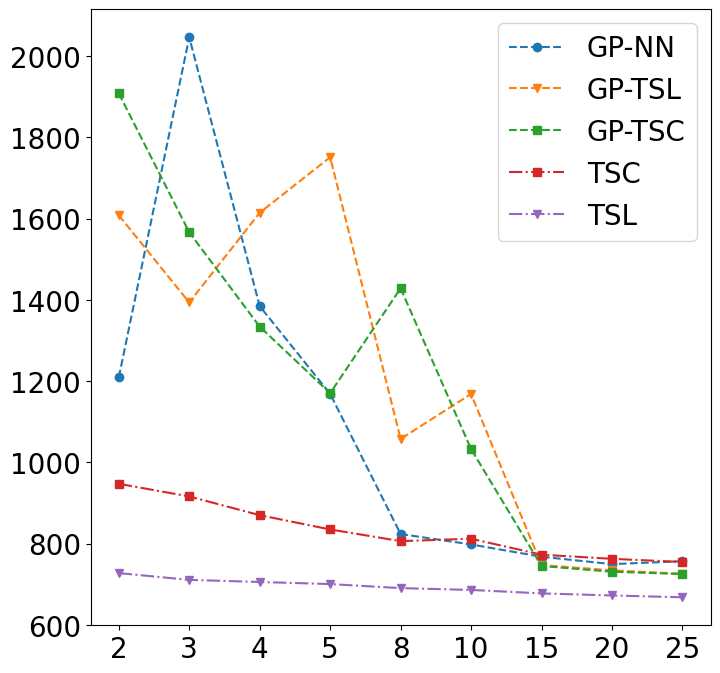

In [128]:
# Plot the results
number_of_rules_array_strings = [str(number) for number in number_of_rules_array]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_nn_tsl_train_accuracy).reshape(-1, 10), axis=1), '--o', label='GP-NN')
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_tsl_train_accuracy).reshape(-1, 10), axis=1), '--v', label='GP-TSL')
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_tsc_train_accuracy).reshape(-1, 10), axis=1), '--s', label='GP-TSC')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsc_train_accuracy).reshape(-1, 10), axis=1), '-.s', label='TSC')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsl_train_accuracy).reshape(-1, 10), axis=1), '-.v', label='TSL')


plt.legend()
plt.show()

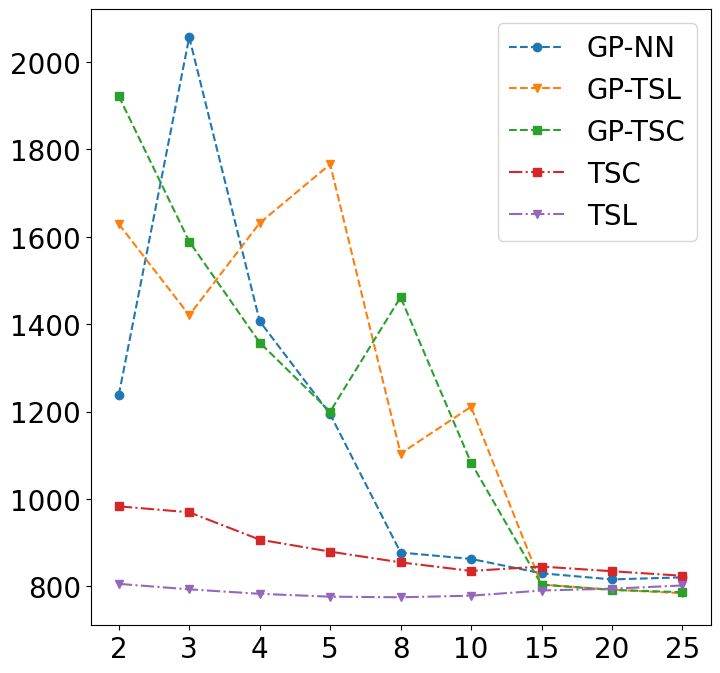

In [127]:
# Plot the results
number_of_rules_array_strings = [str(number) for number in number_of_rules_array]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_nn_tsl_test_accuracy).reshape(-1, 10), axis=1), '--o', label='GP-NN')
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_tsl_test_accuracy).reshape(-1, 10), axis=1), '--v', label='GP-TSL')
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_tsc_test_accuracy).reshape(-1, 10), axis=1), '--s', label='GP-TSC')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsc_test_accuracy).reshape(-1, 10), axis=1), '-.s', label='TSC')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsl_test_accuracy).reshape(-1, 10), axis=1), '-.v', label='TSL')


plt.legend()
plt.show()